In [121]:
import matplotlib.pyplot as plt
from VolatilitySurfaceFunctions import *

## Pricing Vanillas Volatility Surface with Heston

In [122]:
def mainCalculation():
    CP  = OptionType.CALL
    S0  = 100.0
    r   = 0.05
    tau = 2.0

    K = np.linspace(40,200,25)
    K = np.array(K).reshape([len(K),1])

    N = 500
    L = 5

    kappa = 0.1
    gamma = 0.1
    vbar  = 0.1
    rho   = -0.75
    v0    = 0.05

    # Effect of gamma
    plt.figure(1)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    gammaV = [0.1, 0.3, 0.5,0.9]
    legend = []
    for gammaTemp in gammaV:

       # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappa,gammaTemp,vbar,v0,rho)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       legend.append('gamma={0}'.format(gammaTemp))
    plt.legend(legend)

    # Effect of kappa

    plt.figure(2)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    kappaV = [0.1, 0.5, 1.0, 2.0]
    legend = []
    for kappaTemp in kappaV:

        # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappaTemp,gamma,vbar,v0,rho)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       legend.append('kappa={0}'.format(kappaTemp))
    plt.legend(legend)

    # Effect of time-dependence in kappa

    plt.figure(3)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.xlabel('strike, K')
    plt.xlabel('time-to-mautrity T')
    kappaV = [0.1, 0.3, 0.5, 1.0, 2.0]
    legend = []
    Ktemp = [S0]
    maturityGrid = np.linspace(0.1,25,40)

    for kappaTemp in kappaV:
        IV =np.zeros([len(maturityGrid),1])
        for idx, t in enumerate(maturityGrid):

            # Evaluate the Heston model

           cf = ChFHestonModel(r,t,kappaTemp,gamma,vbar,v0,rho)

           # The COS method

           valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, t, Ktemp, N, L)

           # Implied volatilities

           IV[idx] = ImpliedVolatility(CP,valCOS,Ktemp[0],t,S0,r)
        #print(IV)
        plt.plot(maturityGrid,IV*100.0, "-s")
        legend.append('kappa={0}'.format(kappaTemp))
    plt.legend(legend)

    # Effect of time-dependence in v_0

    plt.figure(4)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.xlabel('time-to-mautrity T')
    plt.ylabel('implied volatility')
    v0V = [0.1, 0.3, 0.5, 1.0, 2.0]
    legend = []
    Ktemp = [S0]
    maturityGrid = np.linspace(0.1,25,40)

    for v0Temp in v0V:
        IV =np.zeros([len(maturityGrid),1])
        for idx, t in enumerate(maturityGrid):

            # Evaluate the Heston model

           cf = ChFHestonModel(r,t,kappa,gamma,vbar,v0Temp,rho)

           # The COS method

           valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, t, Ktemp, N, L)

           # Implied volatilities

           IV[idx] = ImpliedVolatility(CP,valCOS,Ktemp[0],t,S0,r)
        plt.plot(maturityGrid,IV*100.0, "-s")
        legend.append('v0={0}'.format(v0Temp))
    plt.legend(legend)

    # Effect of rho

    plt.figure(5)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    rhoV = [0.0, -0.25, -0.5,  -0.9]
    legend = []
    for rhoTemp in rhoV:

       # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappa,gamma,vbar,v0,rhoTemp)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       #plt.plot(K,valCOS)
       legend.append('rho={0}'.format(rhoTemp))
    plt.legend(legend)

    # Effect of vBar

    plt.figure(6)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    vbarV = [0.03, 0.1, 0.2, 0.3]
    legend = []
    for vbarTemp in vbarV:

       # Evaluate the Heston model
       # Compute ChF for the Heston model

       cf = ChFHestonModel(r,tau,kappa,gamma,vbarTemp,v0,rho)

       # The COS method

       valCOS = CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L)

       # Implied volatilities

       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility(CP,valCOS[idx],K[idx],tau,S0,r)
       plt.plot(K,IV*100.0, "-s")
       legend.append('vbar={0}'.format(vbarTemp))
    plt.legend(legend)

#plt.style.use("Solarize_Light2")
plt.style.use("classic")
#plt.style.use("dark_background")
mainCalculation()

## Simulating Heston Dynamics

In [124]:
def mainCalculation2():
    NoOfPaths = 100000
    NoOfSteps = 500

    # Heston model parameters

    gamma = 1.0
    kappa = 0.5
    vbar  = 0.04
    rho   = -0.9
    v0    = 0.04
    T     = 1.0
    S_0   = 100.0
    r     = 0.1
    CP    = OptionType.CALL

    # First we define a range of strikes and check the convergence

    K = np.linspace(0.1,S_0*2.0,30)

    # Exact solution with the COS method

    cf = ChFHestonModel(r,T,kappa,gamma,vbar,v0,rho)

    # The COS method

    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)

    # Euler simulation

    pathsEULER = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_Euler = pathsEULER["S"]

    # Almost exact simulation

    pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
    S_AES = pathsAES["S"]


    OptPrice_EULER = EUOptionPriceFromMCPathsGeneralized(CP,S_Euler[:,-1],K,T,r)
    OptPrice_AES   = EUOptionPriceFromMCPathsGeneralized(CP,S_AES[:,-1],K,T,r)

    plt.figure(figsize=(10,7))
    plt.plot(K,optValueExact,'-r')
    plt.plot(K,OptPrice_EULER,'--k')
    plt.plot(K,OptPrice_AES,'.b')
    plt.legend(['Exact (COS)','Euler','AES'])
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('option price')

    # Here we will analyze the convergence for particular dt

    dtV = np.array([1.0, 1.0/4.0, 1.0/8.0,1.0/16.0,1.0/32.0,1.0/64.0])
    NoOfStepsV = [int(T/x) for x in dtV]

    # Specify strike for analysis

    K = np.array([100.0])

    # Exact

    optValueExact = CallPutOptionPriceCOSMthd(cf, CP, S_0, r, T, K, 1000, 8)
    errorEuler = np.zeros([len(dtV),1])
    errorAES = np.zeros([len(dtV),1])

    for (idx,NoOfSteps) in enumerate(NoOfStepsV):

        # Euler

        np.random.seed(3)
        pathsEULER = GeneratePathsHestonEuler(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_Euler = pathsEULER["S"]
        OptPriceEULER = EUOptionPriceFromMCPathsGeneralized(CP,S_Euler[:,-1],K,T,r)
        errorEuler[idx] = OptPriceEULER-optValueExact

        # AES

        np.random.seed(3)
        pathsAES = GeneratePathsHestonAES(NoOfPaths,NoOfSteps,T,r,S_0,kappa,gamma,rho,vbar,v0)
        S_AES = pathsAES["S"]
        OptPriceAES   = EUOptionPriceFromMCPathsGeneralized(CP,S_AES[:,-1],K,T,r)
        errorAES[idx] = OptPriceAES-optValueExact

    # Print the results

    for i in range(0,len(NoOfStepsV)):
        print("Euler Scheme, K ={0}, dt = {1} = {2}".format(K,dtV[i],errorEuler[i]))

    for i in range(0,len(NoOfStepsV)):
        print("AES Scheme, K ={0}, dt = {1} = {2}".format(K,dtV[i],errorAES[i]))

mainCalculation2()

## Example of Expected Exposure computation

<Figure size 640x480 with 0 Axes>

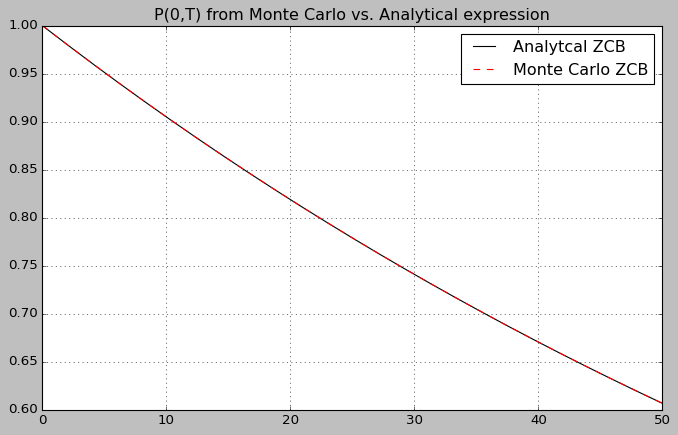

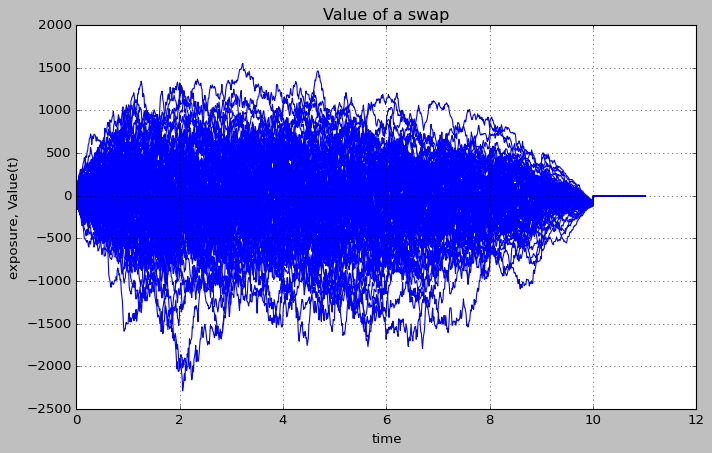

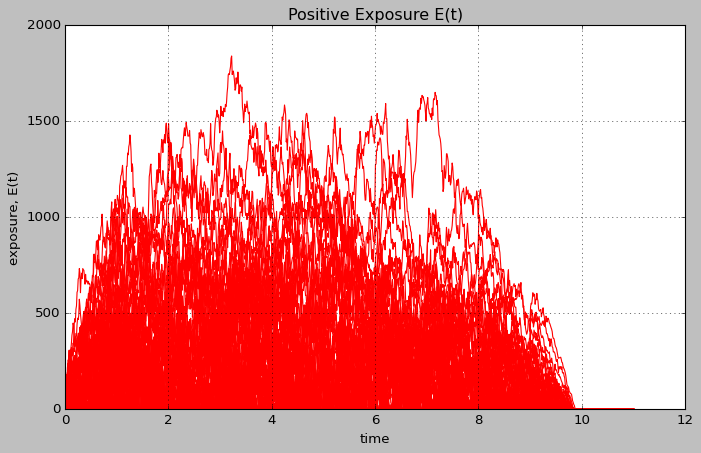

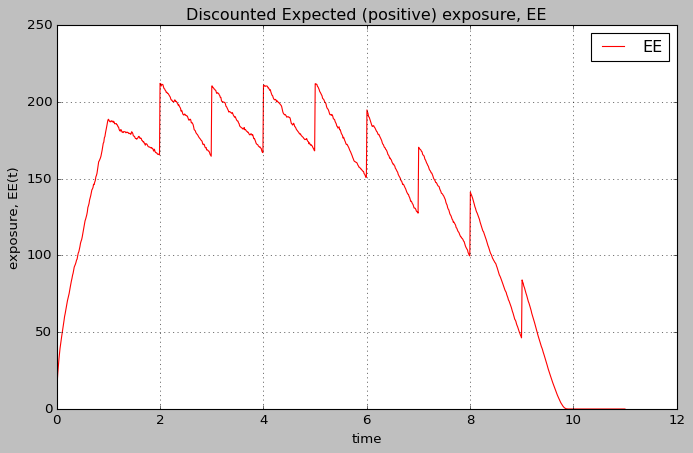

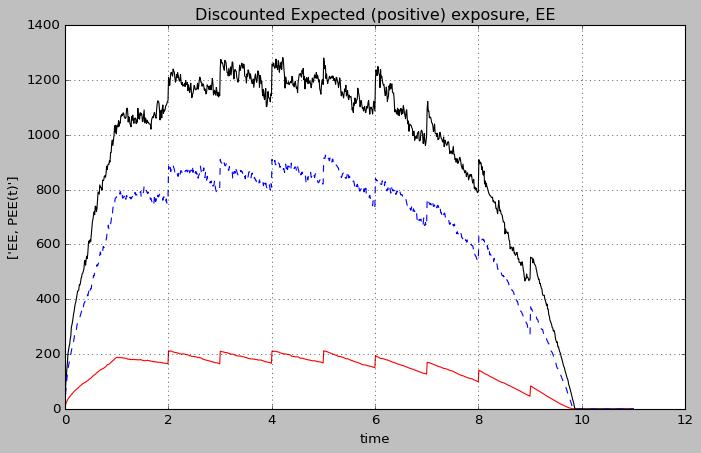

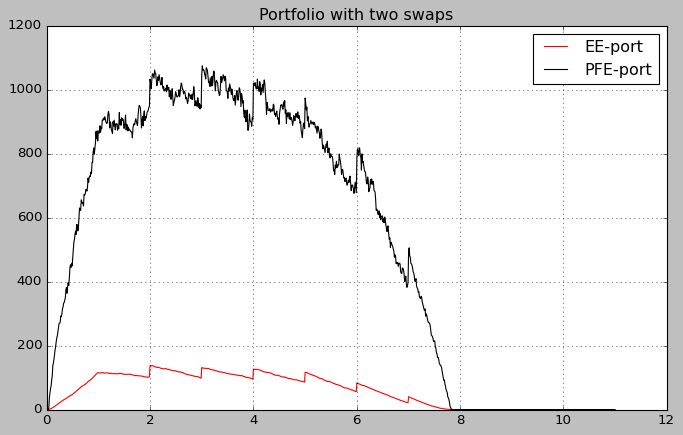

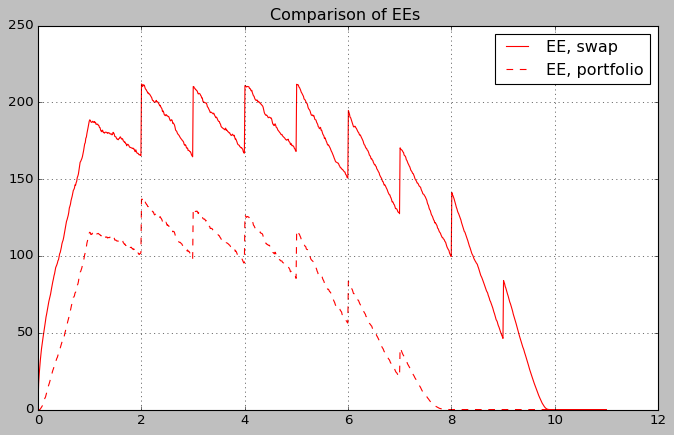

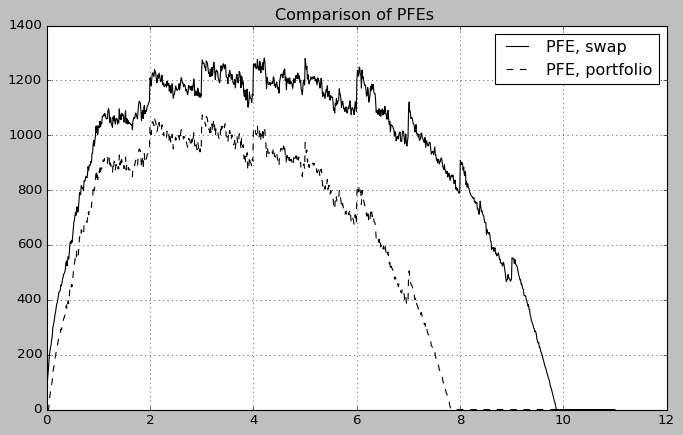

In [126]:
def mainCalculation3():
    NoOfPaths = 2000
    NoOfSteps = 1000
    CP = OptionTypeSwap.PAYER
    lambd     = 0.5
    eta       = 0.03
    notional  = 10000.0
    notional2 = 10000.0
    alpha     = 0.99
    alpha2     = 0.95

    # We define a ZCB curve (obtained from the market)

    P0T = lambda T: np.exp(-0.01*T)#np.exp(-0.03*T*T-0.1*T)
    r0 = HW_r_0(P0T,lambd,eta)

    # In this experiment we compare for the ZCB the market and analytic expressions

    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)

    Exact = np.zeros([N,1])
    Proxy= np.zeros ([N,1])
    for i,Ti in enumerate(Tgrid):
        Proxy[i] = HW_ZCB(lambd,eta,P0T,0.0,Ti,r0)
        Exact[i] = P0T(Ti)

    plt.figure(1)
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(Tgrid,Exact,'-k')
    plt.plot(Tgrid,Proxy,'--r')
    plt.legend(["Analytcal ZCB","Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')


    # Here we simulate the exposure profiles for a swap, using the HW model
    # Swap settings

    K = 0.01  # Strike
    Ti = 1.0  # Beginning of the swap
    Tm = 10.0 # End date of the swap
    n = 10    # Number of payments between Ti and Tm

    paths= GeneratePathsHWEuler(NoOfPaths,NoOfSteps,Tm+1.0 ,P0T, lambd, eta)
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1]-timeGrid[0]

    # Here we compare the price of an option on a ZCB from Monte Carlo and analytic expression

    M_t = np.zeros([NoOfPaths,NoOfSteps])

    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)

    # Portfolio without netting

    Value= np.zeros([NoOfPaths,NoOfSteps+1])
    E  = np.zeros([NoOfPaths,NoOfSteps+1])
    EE = np.zeros([NoOfSteps+1])
    PFE = np.zeros([NoOfSteps+1])
    PFE2 = np.zeros([NoOfSteps+1])
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        V = HW_SwapPrice(CP,notional,K,timeGrid[idx],Ti,Tm,n,r[:,idx],P0T,lambd,eta)
        Value[:,idx] = V / np.squeeze(M_t[:,idx])
        E[:,idx] = np.maximum(V,0.0)
        EE[idx] = np.mean(E[:,idx]/M_t[:,idx])
        PFE[idx] = np.quantile(E[:,idx],alpha)
        PFE2[idx] = np.quantile(E[:,idx],alpha2)

    # Portfolio with netting

    ValuePort = np.zeros([NoOfPaths,NoOfSteps+1])
    EPort  = np.zeros([NoOfPaths,NoOfSteps+1])
    EEPort = np.zeros([NoOfSteps+1])
    PFEPort = np.zeros([NoOfSteps+1])
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        Swap1 = HW_SwapPrice(CP,notional,K,timeGrid[idx],Ti,Tm,n,r[:,idx],P0T,lambd,eta)
        Swap2 = HW_SwapPrice(CP,notional2,0.0,timeGrid[idx],Tm-2.0*(Tm-Ti)/n,Tm,1,r[:,idx],P0T,lambd,eta)

        VPort = Swap1 - Swap2
        ValuePort[:,idx] = VPort / np.squeeze(M_t[:,idx])
        EPort[:,idx] = np.maximum(VPort,0.0)
        EEPort[idx] = np.mean(EPort[:,idx]/M_t[:,idx])
        PFEPort[idx] = np.quantile(EPort[:,idx],alpha)

    plt.figure(2)
    plt.figure(figsize=(10,6))
    plt.plot(timeGrid,Value[0:100,:].transpose(),'b')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, Value(t)')
    plt.title('Value of a swap')

    plt.figure(3)
    plt.figure(figsize=(10,6))
    plt.plot(timeGrid,E[0:100,:].transpose(),'r')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, E(t)')
    plt.title('Positive Exposure E(t)')

    plt.figure(4)
    plt.figure(figsize=(10,6))
    plt.plot(timeGrid,EE,'r')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel('exposure, EE(t)')
    plt.title('Discounted Expected (positive) exposure, EE')
    plt.legend(['EE','PFE'])

    plt.figure(5)
    plt.figure(figsize=(10,6))
    plt.plot(timeGrid,EE,'r')
    plt.plot(timeGrid,PFE,'k')
    plt.plot(timeGrid,PFE2,'--b')
    plt.grid()
    plt.xlabel('time')
    plt.ylabel(['EE, PEE(t)'])
    plt.title('Discounted Expected (positive) exposure, EE')

    plt.figure(6)
    plt.figure(figsize=(10,6))
    plt.plot(timeGrid,EEPort,'r')
    plt.plot(timeGrid,PFEPort,'k')
    plt.grid()
    plt.title('Portfolio with two swaps')
    plt.legend(['EE-port','PFE-port'])

    plt.figure(7)
    plt.figure(figsize=(10,6))
    plt.plot(timeGrid,EE,'r')
    plt.plot(timeGrid,EEPort,'--r')
    plt.grid()
    plt.title('Comparison of EEs ')
    plt.legend(['EE, swap','EE, portfolio'])

    plt.figure(8)
    plt.figure(figsize=(10,6))
    plt.plot(timeGrid,PFE,'k')
    plt.plot(timeGrid,PFEPort,'--k')
    plt.grid()
    plt.title('Comparison of PFEs ')
    plt.legend(['PFE, swap','PFE, portfolio'])

mainCalculation3()